In [2]:
from functions import *

768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


D:\anaconda3\envs\dcaesr\lib\site-packages\torch\serialization.py:1525: UserWarning: This figure was saved with matplotlib version 3.7.1 and is unlikely to function correctly.
  result = unpickler.load()


768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


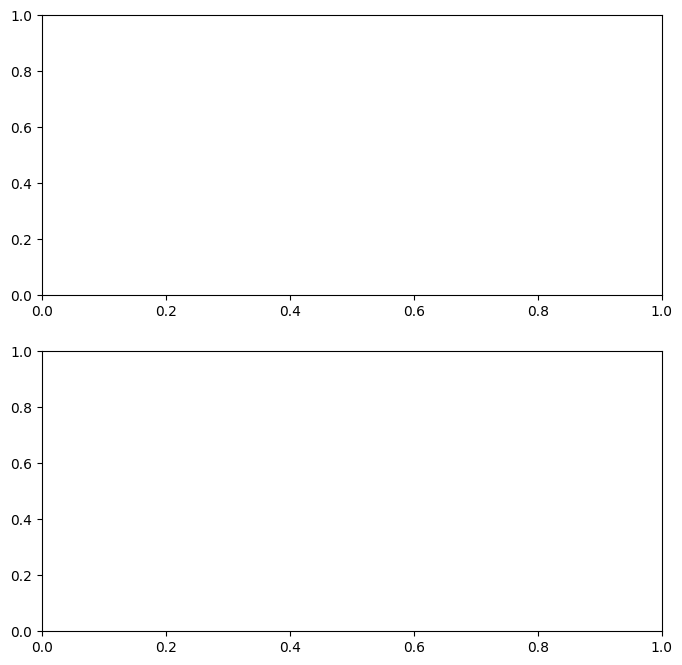

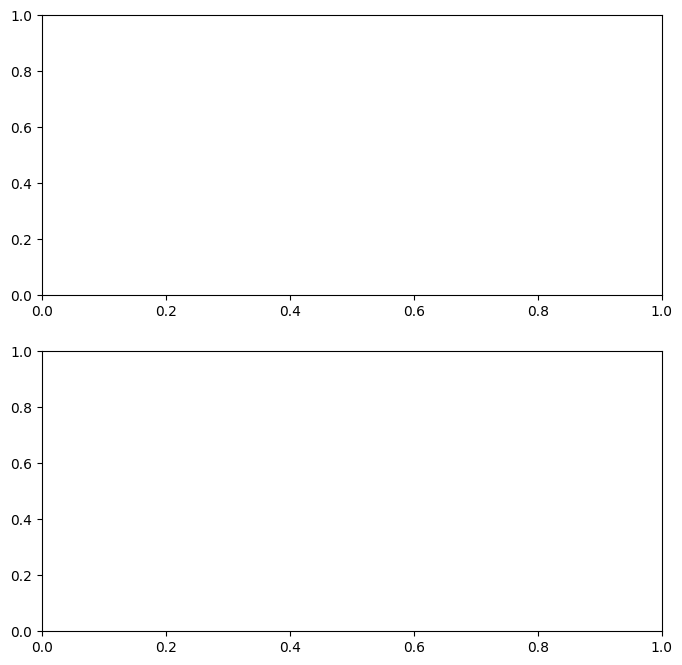

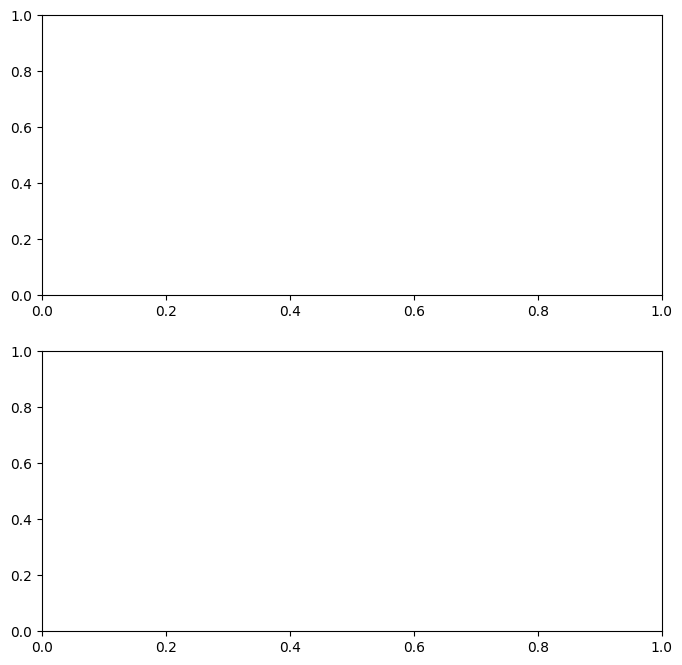

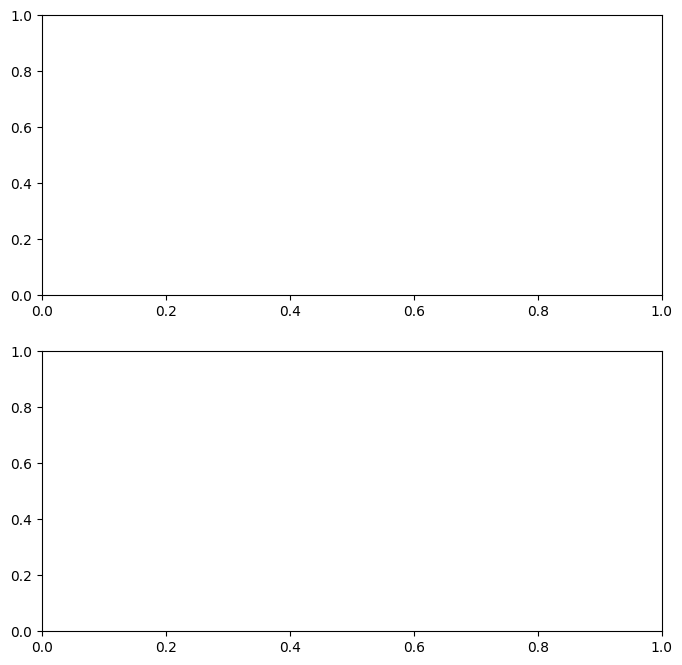

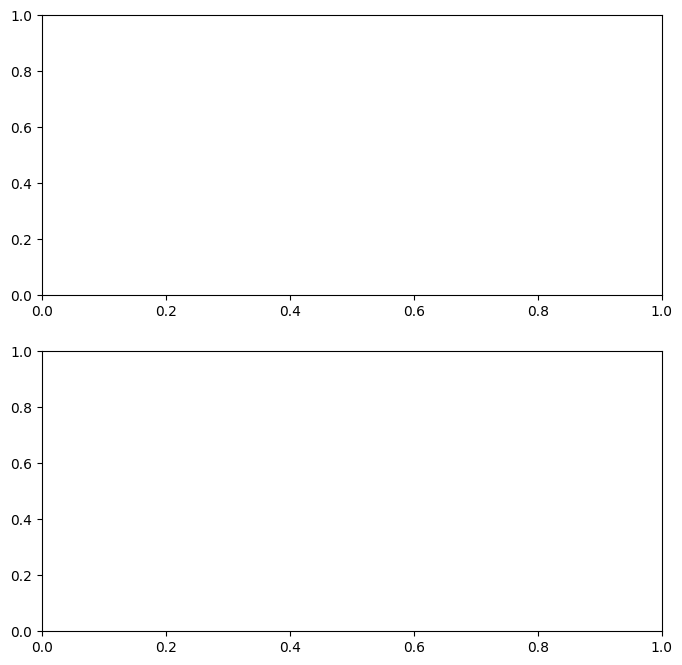

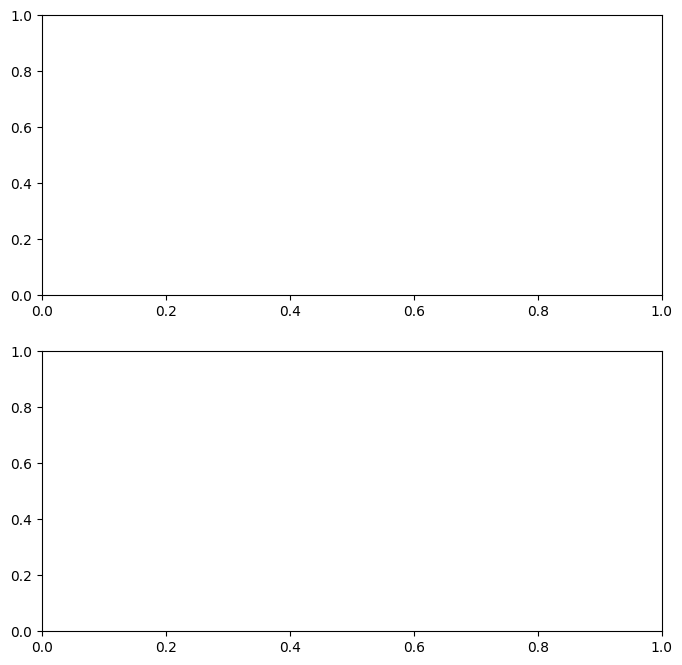

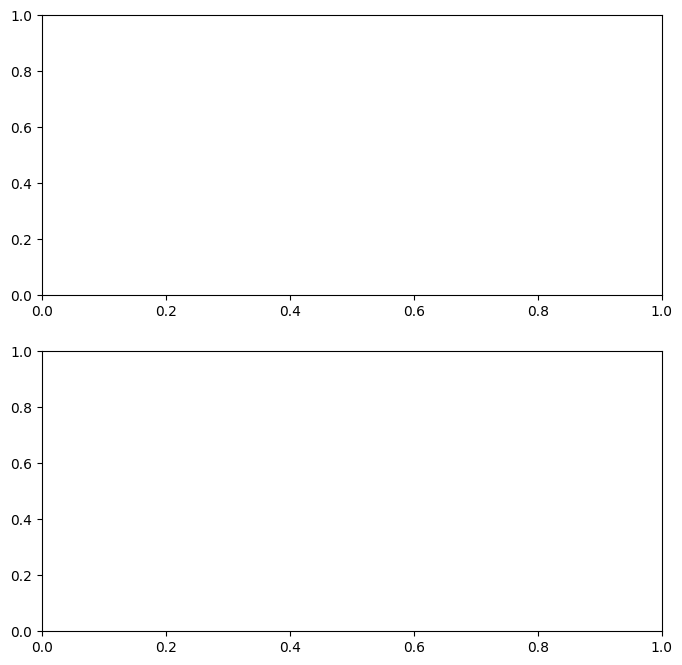

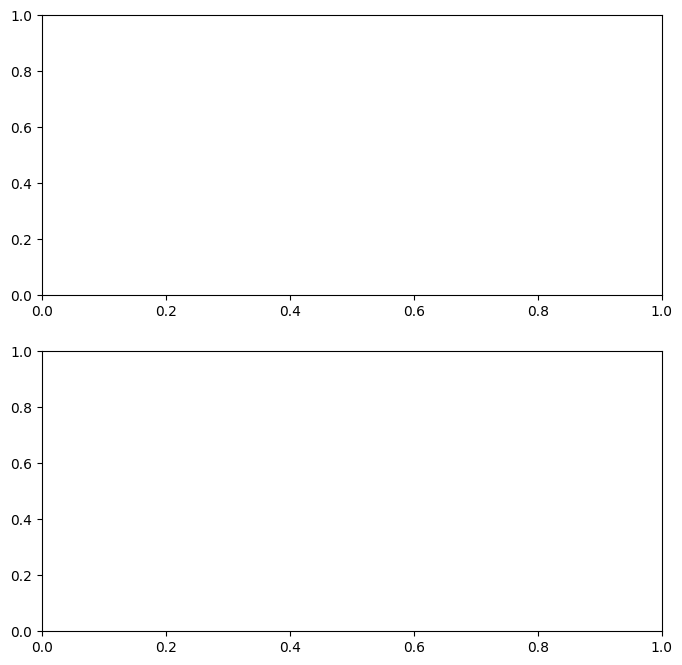

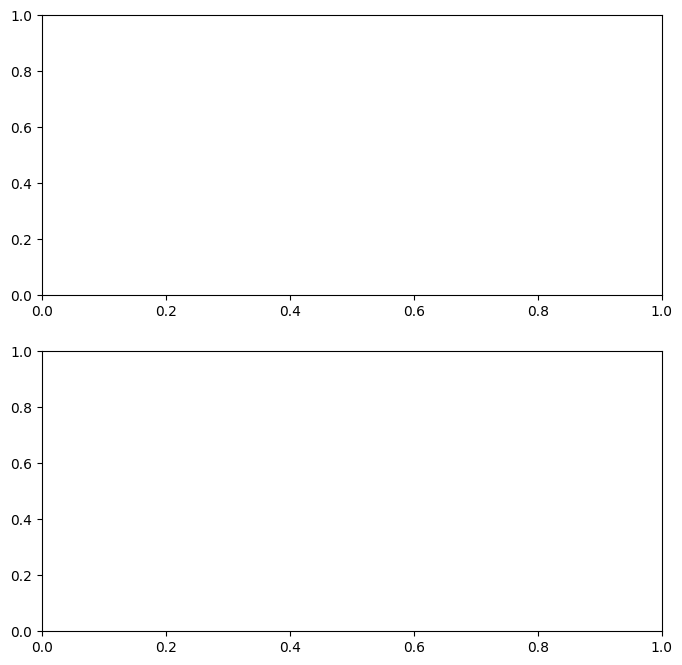

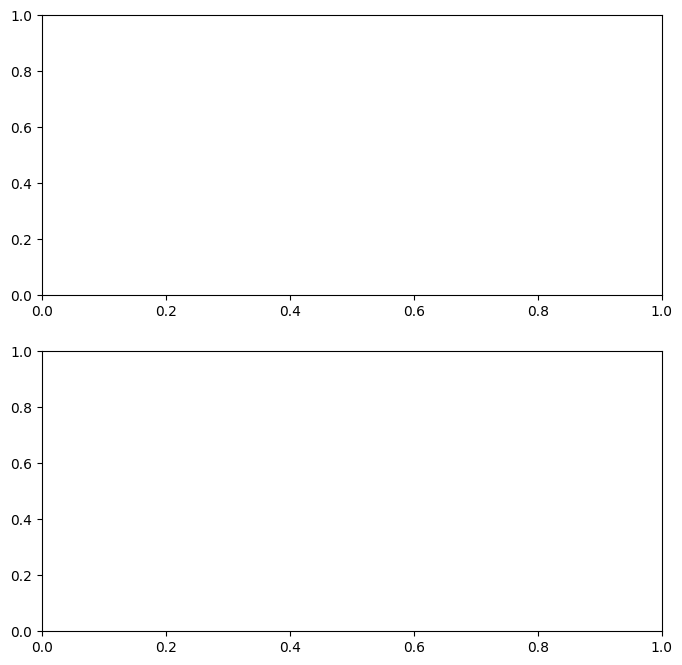

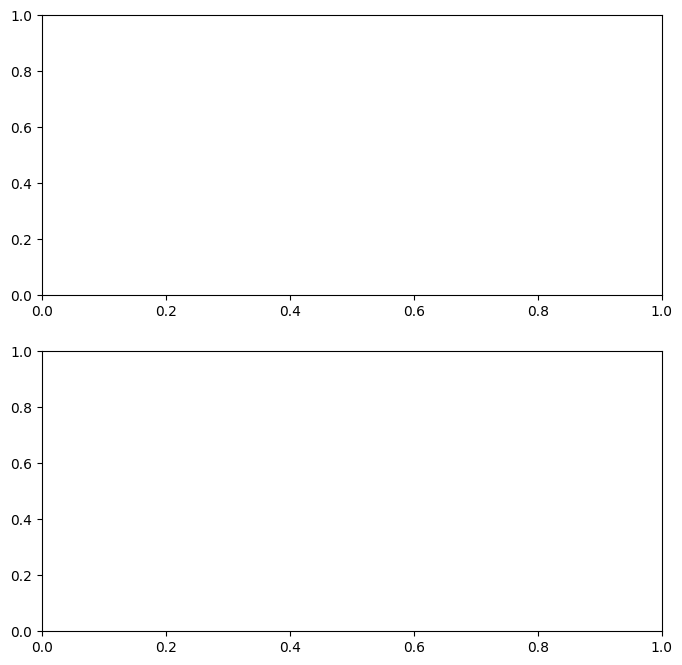

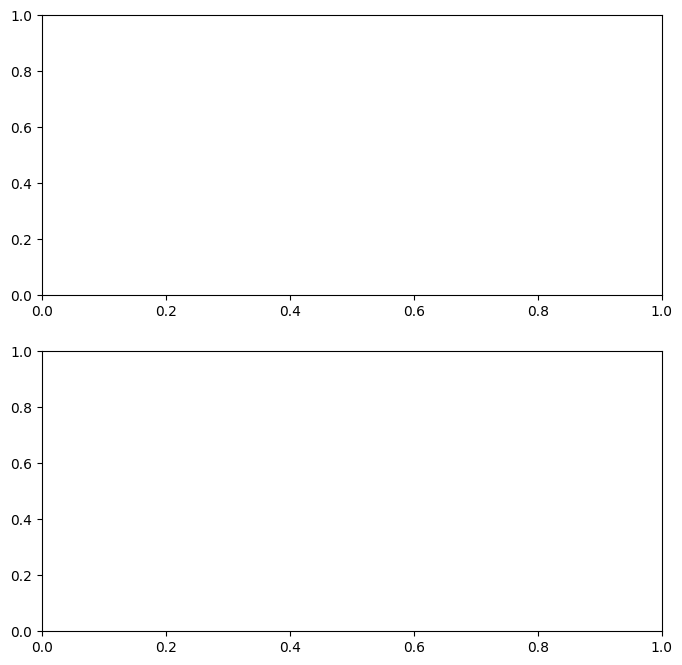

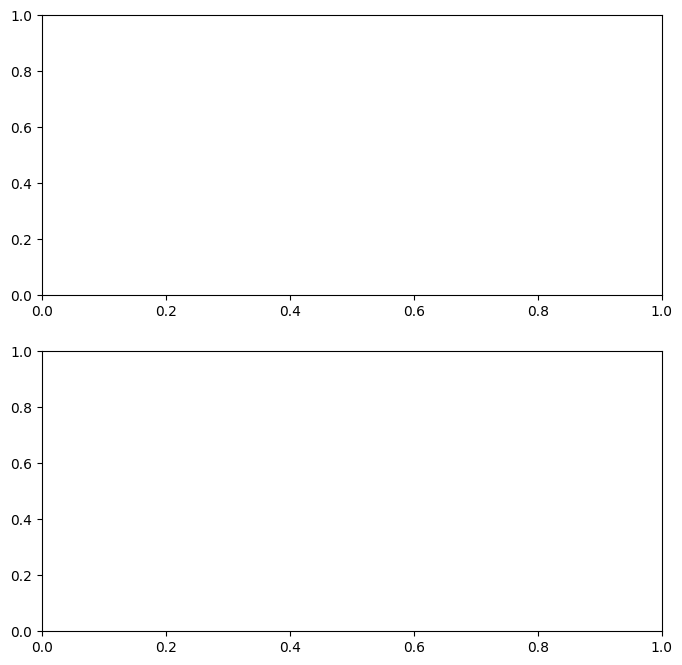

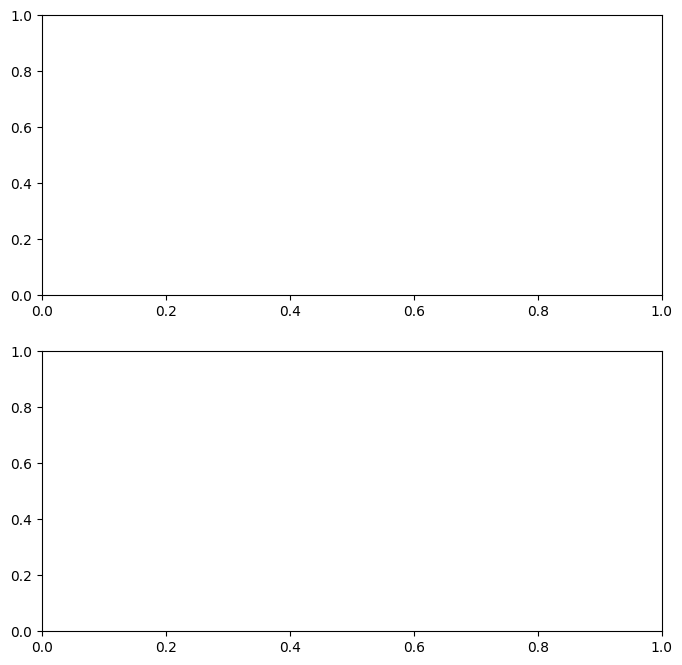

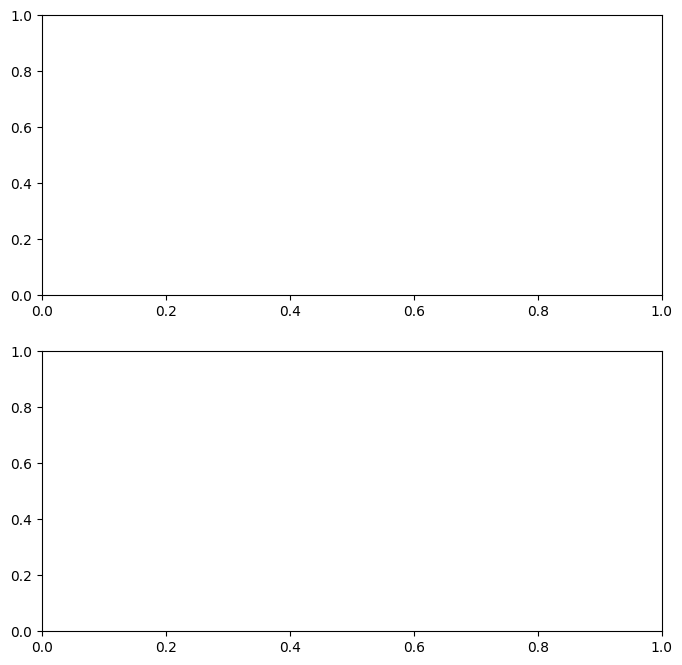

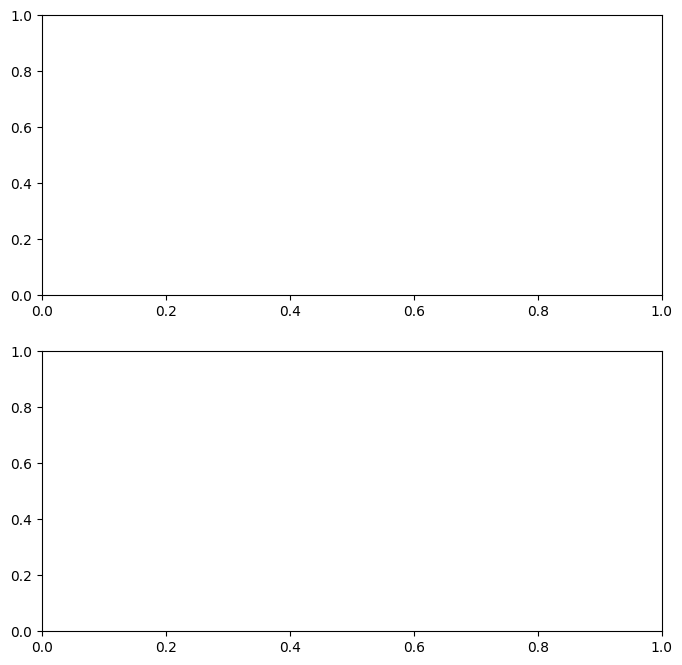

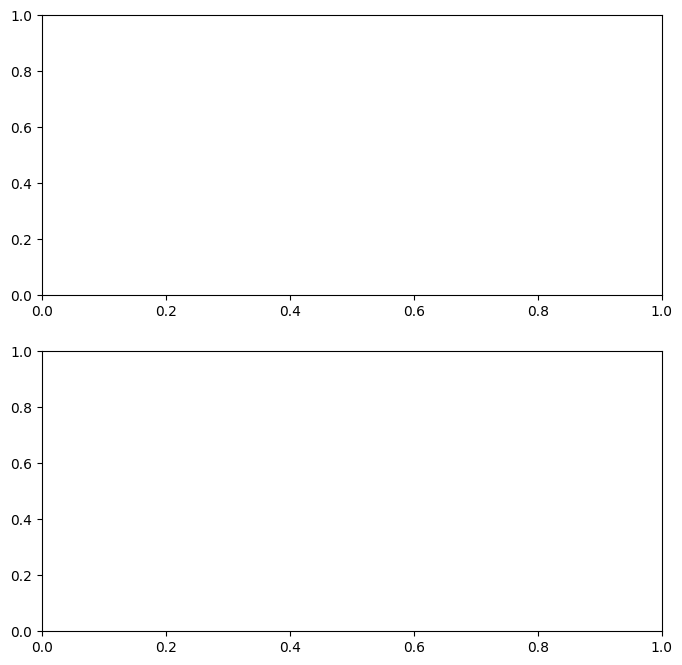

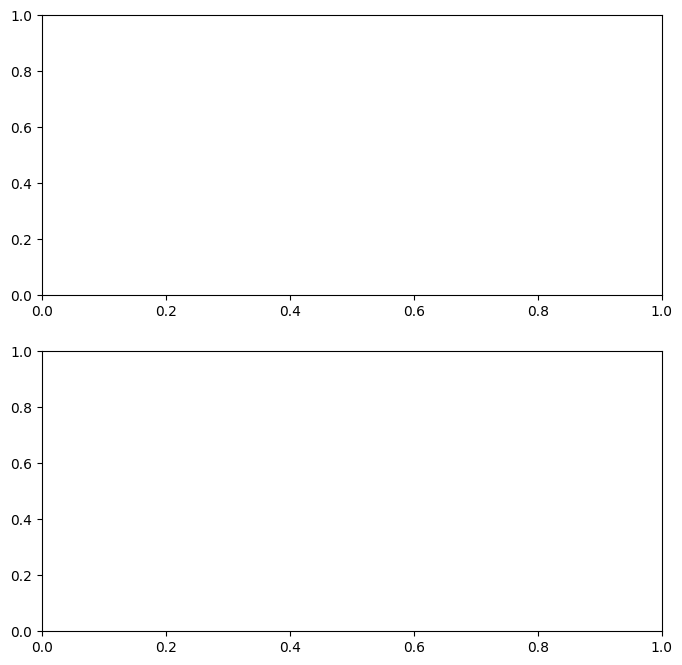

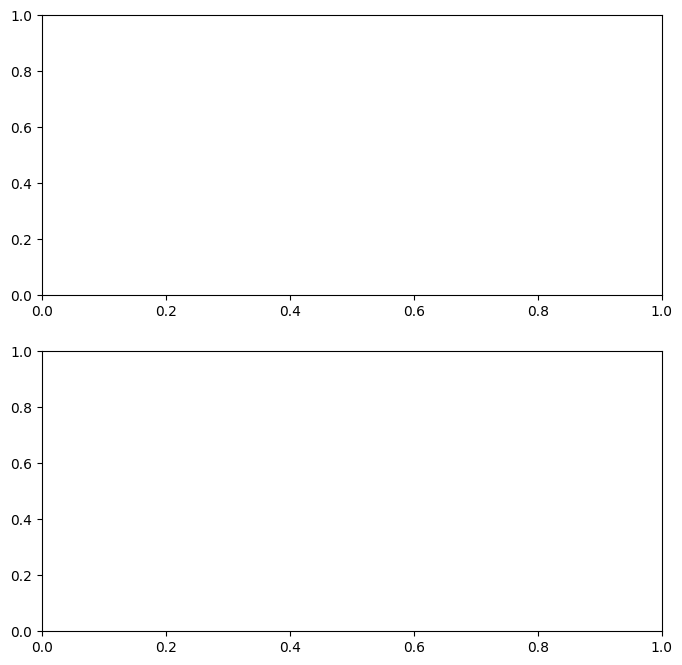

In [3]:
import torch 
from functions import load_models

device = "cuda:0" if torch.cuda.is_available() else "cpu"
models, cant_load = load_models(device)

In [4]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_performances(performances):
    
    #scaler = StandardScaler()
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_performances = scaler.fit_transform(performances.reshape(-1, 1))
    return scaled_performances

In [6]:
import pandas as pd 
models_performance = {
    "denoising_hr": [0.0069, 0.9935, 23.45],
    "denoising_lrhr": [0.0058, 0.9942, 24.62],
    "denoising_lrhr_v2": [0.0040, 0.9979, 25.7013],
    "denoising_nosr": [0.0073, 0.9939, 23.00],
    "nodenoising": [0.0686, 0.9410, 16.71],
    "nodenoising_nosr": [0.1363, 0.9169, 14.1703]
}
# Convert to DataFrame
performance_df = pd.DataFrame(models_performance).T
performance_df.columns = ['MSE', 'SSIM', 'PSNR']
performance_df.index.name = 'Model'
performance_df

,MSE,SSIM,PSNR
Model,,,
denoising_hr,0.0069,0.9935,23.4500
denoising_lrhr,0.0058,0.9942,24.6200
denoising_lrhr_v2,0.0040,0.9979,25.7013
denoising_nosr,0.0073,0.9939,23.0000
nodenoising,0.0686,0.9410,16.7100
nodenoising_nosr,0.1363,0.9169,14.1703


In [7]:
labels = ["MI", "STTC", "CD", "HYP", "NORM"]

In [9]:
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
dict_windows_train_hr = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data
    
    
    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data
    
    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

In [10]:
from torch.functional import F
def compute_mse(signals_sr, signals_hr):
    losses = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        mse_loss = F.mse_loss(signal_sr, signal_hr)
        losses.append(mse_loss.item())
    return losses, np.mean(losses)

In [11]:
def ssim_2d(signal1, signal2):
    """
    Compute the Structural Similarity Index (SSIM) for two-dimensional signals.

    Parameters:
    - signal1, signal2: Input signals.

    Returns:
    - ssim_index: Structural Similarity Index between the two signals.
    """

    # Ensure the signals have the same shape
    if signal1.shape != signal2.shape:
        raise ValueError("Input signals must have the same shape")

    # Constants for SSIM calculation
    C1 = (0.01 * np.amax(signal1) - np.amin(signal1))**2
    C2 = (0.01 * np.amax(signal2) - np.amin(signal2))**2

    # Mean and variance
    mu1 = np.mean(signal1)
    mu2 = np.mean(signal2)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = np.var(signal1)
    sigma2_sq = np.var(signal2)
    sigma12 = np.cov(signal1.flatten(), signal2.flatten())[0, 1]

    # SSIM calculation
    num = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    den = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    #print(num, den)
    ssim_index = num / den

    return ssim_index

In [12]:
def compute_ssim(signals_sr, signals_hr):

    ssims = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        ssim = ssim_2d(signal_hr, signal_sr)
        ssims.append(ssim)
    return ssims, np.mean(ssims)

In [13]:
def psnr_2d(original, reconstructed):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) for two-dimensional signals.

    Parameters:
    - original: Original signal.
    - reconstructed: Reconstructed signal.

    Returns:
    - psnr_value: PSNR value between the original and reconstructed signals.
    """

    # Ensure the signals have the same shape
    if original.shape != reconstructed.shape:
        raise ValueError("Input signals must have the same shape")

    # Calculate the mean squared error
    mse = np.mean((original - reconstructed)**2)

    # The maximum possible pixel value (assuming the signal is in the range [0, 1])
    max_pixel_value = 1.0

    # Calculate PSNR
    psnr_value = 10 * np.log10((max_pixel_value**2) / mse)

    return psnr_value

In [14]:
def compute_psnr(signals_hr, signals_sr):

    psnrs = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        psnr = psnr_2d(signal_hr, signal_sr)
        psnrs.append(psnr)
    return psnrs, np.mean(psnrs)

In [15]:
def predict_sr(signal, nchs=12):

    global model
    global device
    
    if signal.ndim == 2:
        signal = signal.unsqueeze(dim = 0)
    if signal.ndim == 3:
        signal = signal.unsqueeze(dim = 0)
    pred = model([signal, None, None, None])
    signal_sr = pred[1]
    signal_rec = pred[0]
    if signal_sr is None:
        signal_rec = signal_rec.unsqueeze(dim = 0).cpu().detach().numpy()
        signal_sr = resample(signal_rec, size = 2500)
        signal_sr = torch.from_numpy(signal_sr)
    if signal_sr.ndim == 2:
        signal_sr = signal_sr.unsqueeze(dim = 0)
    
    #print(signal_sr.shape)
    del pred
    del signal
    return signal_sr

In [16]:
def compute_sr(signals, nchs = 12):
    signals_sr = []
    n = len(signals)
    for i, signal in enumerate(signals):
        print("\r", i+1, "/", n, end = "")
        signal_sr = predict_sr(signal, nchs=nchs)
        signals_sr.append(signal_sr)

    return signals_sr

In [17]:
import gc 

gc.collect()
torch.cuda.empty_cache()

mses_all = {}
psnrs_all = {}
ssims_all = {}

for modelname, model in models.items():
        
    mses_all[modelname] = []
    psnrs_all[modelname] = []
    ssims_all[modelname] = []
    print(modelname)
    
    for label in labels:

        print(label)
        signals_test_hr = dict_windows_test_hr[label]
        signals_test_lr = dict_windows_test_lr_n[label]
        
        signals_test_sr = compute_sr(signals_test_lr)
        mses, mse = compute_mse(signals_test_sr, signals_test_hr)
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

        [mses_all[modelname].append(value) for value in mses]
        [ssims_all[modelname].append(value) for value in ssims]
        [psnrs_all[modelname].append(value) for value in psnrs]
        del ssims 
        del psnrs
        del mses
        del signals_test_sr
        del signals_test_lr
        del signals_test_hr

denoising_hr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926denoising_lrhr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926denoising_lrhr_v2
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926denoising_nosr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926nodenoising
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926nodenoising_nosr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926

In [18]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

In [32]:
import pandas as pd

# Creating a DataFrame for the performance metrics
n = len(mses_all["denoising_nosr"])
print(n)


mses_in = []
models_in = []
ssims_in = []
psnrs_in = [] 

for modelname in ["denoising_nosr", "denoising_hr", "denoising_lrhr"]:

    if modelname == "denoising_nosr":
        losstype = "LR"
    elif modelname == "denoising_hr":
        losstype = "HR"
    else:
        losstype = "LR+HR"
    
    mses = mses_all[modelname]
    [mses_in.append(value) for value in mses]
    [models_in.append(losstype) for value in mses]
    ssims = ssims_all[modelname]
    [ssims_in.append(value) for value in ssims]
    psnrs = psnrs_all[modelname]
    [psnrs_in.append(value) for value in psnrs]

4316


In [33]:
len(models_in)

12948

In [34]:
data = {
    "Model": models_in,
    "MSE": mses_in,
    "PSNR": psnrs_in,
    "SSIM": ssims_in
}

long_df = pd.DataFrame(data)
long_df

,Model,MSE,PSNR,SSIM
0,LR,0.003238,24.897680,0.996839
1,LR,0.003140,25.030039,0.996798
2,LR,0.013712,18.628896,0.990549
3,LR,0.019606,17.076007,0.987084
4,LR,0.003592,24.446825,0.997034
...,...,...,...,...
12943,LR+HR,0.001054,29.773506,0.998305
12944,LR+HR,0.001256,29.011802,0.998174
12945,LR+HR,0.000791,31.019151,0.998842
12946,LR+HR,0.006935,21.589741,0.993646


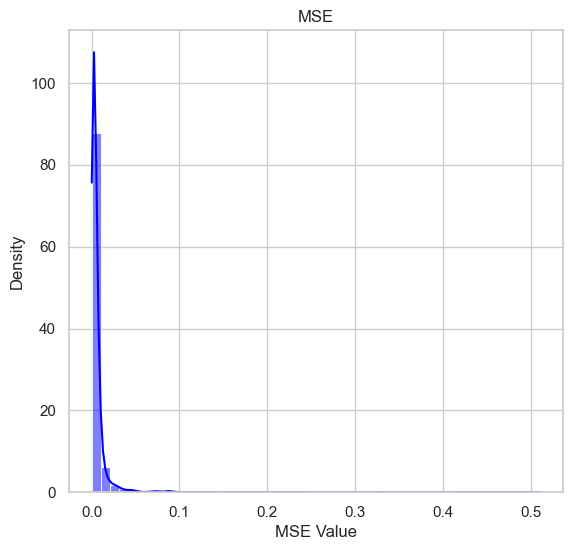

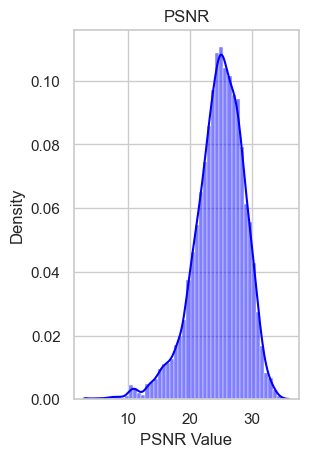

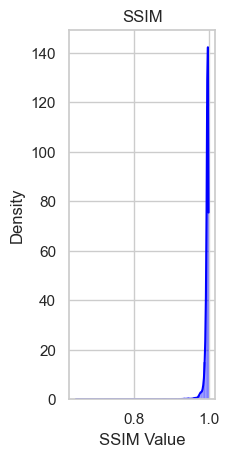

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Histogram for MSE
plt.subplot(1, 2, 1)
sns.histplot(mses_in, bins=50, kde=True, color='blue', stat='density')
plt.title('MSE')
plt.xlabel('MSE Value')
plt.ylabel('Density')
plt.show()

# Histogram for PSNR
plt.subplot(1, 2, 1)
sns.histplot(psnrs_in, bins=50, kde=True, color='blue', stat='density')
plt.title('PSNR')
plt.xlabel('PSNR Value')
plt.ylabel('Density')
plt.show()

# Histogram for Low-Resolution Signals
plt.subplot(1, 3, 1)
sns.histplot(ssims_in, bins=50, kde=True, color='blue', stat='density')
plt.title('SSIM')
plt.xlabel('SSIM Value')
plt.ylabel('Density')
plt.show()

In [60]:
from scipy.stats import wilcoxon

pvalues = {}

for modelname in ["denoising_nosr", "denoising_hr", "denoising_lrhr"]:
    if modelname == "denoising_nosr":
        losstype = "LR"
    elif modelname == "denoising_hr":
        losstype = "HR"
    else:
        losstype = "LR+HR"
    for modelname2 in ["denoising_nosr", "denoising_hr", "denoising_lrhr"]:
        if modelname2 == "denoising_nosr":
            losstype2 = "LR"
        elif modelname2 == "denoising_hr":
            losstype2 = "HR"
        else:
            losstype2 = "LR+HR"
                
        if modelname != modelname2:
            x1 = mses_all[modelname]
            x2 = mses_all[modelname2]
            statistic, pvalue = wilcoxon(x1, x2)
            pvalues["{} vs {}".format(losstype, losstype2)] = pvalue
pvalues

{'LR vs HR': 0.0,
 'LR vs LR+HR': 0.0,
 'HR vs LR': 0.0,
 'HR vs LR+HR': 7.034967356841214e-69,
 'LR+HR vs LR': 0.0,
 'LR+HR vs HR': 7.034967356841214e-69}

In [183]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = long_df["PSNR"], groups = long_df["Model"], alpha = 0.05)

# Convert the results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# Format p-adj to display in scientific notation
tukey_df['p-adj'] = tukey_df['p-adj'].map(lambda x: f"{x:.4}")
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,HR,LR,-2.2547,0.0,-2.4524,-2.0570,True
1,HR,LR+HR,-0.3005,0.0011,-0.4982,-0.1028,True
2,LR,LR+HR,1.9542,0.0,1.7565,2.1519,True


Table 12

In [62]:
mses_in = []
models_in = []
ssims_in = []
psnrs_in = [] 

for modelname in ["denoising_lrhr", "denoising_lrhr_v2"]:

    if modelname == "denoising_lrhr":
        lasttanh = "X"
    else:
        lasttanh = "V"
    
    mses = mses_all[modelname]
    [mses_in.append(value) for value in mses]
    [models_in.append(lasttanh) for value in mses]
    ssims = ssims_all[modelname]
    [ssims_in.append(value) for value in ssims]
    psnrs = psnrs_all[modelname]
    [psnrs_in.append(value) for value in psnrs]

In [64]:
data = {
    "Model": models_in,
    "MSE": mses_in,
    "PSNR": psnrs_in,
    "SSIM": ssims_in
}

long_df = pd.DataFrame(data)
long_df

,Model,MSE,PSNR,SSIM
0,X,0.002284,26.413444,0.997673
1,X,0.002134,26.708404,0.997812
2,X,0.015170,18.190130,0.986693
3,X,0.020318,16.921088,0.982590
4,X,0.002186,26.602967,0.997881
...,...,...,...,...
8627,V,0.001172,29.310412,0.997444
8628,V,0.001713,27.661987,0.996897
8629,V,0.000878,30.564198,0.998393
8630,V,0.002333,26.320169,0.999303


In [70]:
from scipy.stats import wilcoxon

pvalues = {}

for modelname in ["denoising_lrhr", "denoising_lrhr_v2"]:

    if modelname == "denoising_lrhr":
        lasttanh = "X"
    else:
        lasttanh = "V"

    for modelname2 in ["denoising_lrhr", "denoising_lrhr_v2"]:
        if modelname2 == "denoising_lrhr":
            lasttanh2 = "X"
        else:
            lasttanh2 = "V"
        
        if modelname != modelname2:
            x1 = mses_all[modelname]
            x2 = mses_all[modelname2]
            statistic, pvalue = wilcoxon(x1, x2)
            pvalues["{} vs {}".format(lasttanh, lasttanh2)] = pvalue
pvalues

{'X vs V': 6.729199066794189e-182, 'V vs X': 6.729199066794189e-182}

In [199]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = long_df["PSNR"], groups = long_df["Model"], alpha = 0.05)

# Convert the results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# Format p-adj to display in scientific notation
tukey_df['p-adj'] = tukey_df['p-adj'].map(lambda x: f"{x:.4e}")
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,V,X,-0.7997,0.0000e+00,-0.9597,-0.6398,True


Table 9

In [205]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

In [76]:
mses_in = []
models_in = []
ssims_in = []
psnrs_in = [] 

for modelname in ["nodenoising_nosr", "nodenoising", "denoising_nosr", "denoising_lrhr"]:
    
    mses = mses_all[modelname]
    [mses_in.append(value) for value in mses]
    [models_in.append(modelname) for value in mses]
    ssims = ssims_all[modelname]
    [ssims_in.append(value) for value in ssims]
    psnrs = psnrs_all[modelname]
    [psnrs_in.append(value) for value in psnrs]

In [78]:
data = {
    "Model": models_in,
    "MSE": mses_in,
    "PSNR": psnrs_in,
    "SSIM": ssims_in
}

long_df = pd.DataFrame(data)
long_df

,Model,MSE,PSNR,SSIM
0,nodenoising_nosr,0.003429,24.648620,0.996599
1,nodenoising_nosr,0.003152,25.014525,0.996721
2,nodenoising_nosr,0.553649,2.567651,0.736297
3,nodenoising_nosr,0.554266,2.562816,0.738026
4,nodenoising_nosr,0.003421,24.658151,0.997053
...,...,...,...,...
17259,denoising_lrhr,0.001054,29.773506,0.998305
17260,denoising_lrhr,0.001256,29.011802,0.998174
17261,denoising_lrhr,0.000791,31.019151,0.998842
17262,denoising_lrhr,0.006935,21.589741,0.993646


In [84]:
from scipy.stats import wilcoxon

pvalues = {}

for modelname in ["nodenoising_nosr", "nodenoising", "denoising_nosr", "denoising_lrhr"]:
    for modelname2 in ["nodenoising_nosr", "nodenoising", "denoising_nosr", "denoising_lrhr"]:
        if modelname != modelname2:
            x1 = psnrs_all[modelname]
            x2 = psnrs_all[modelname2]
            statistic, pvalue = wilcoxon(x1, x2)
            pvalues["{} vs {}".format(modelname, modelname2)] = pvalue
pvalues

{'nodenoising_nosr vs nodenoising': 0.0,
 'nodenoising_nosr vs denoising_nosr': 0.0,
 'nodenoising_nosr vs denoising_lrhr': 0.0,
 'nodenoising vs nodenoising_nosr': 0.0,
 'nodenoising vs denoising_nosr': 0.0,
 'nodenoising vs denoising_lrhr': 0.0,
 'denoising_nosr vs nodenoising_nosr': 0.0,
 'denoising_nosr vs nodenoising': 0.0,
 'denoising_nosr vs denoising_lrhr': 0.0,
 'denoising_lrhr vs nodenoising_nosr': 0.0,
 'denoising_lrhr vs nodenoising': 0.0,
 'denoising_lrhr vs denoising_nosr': 0.0}

In [219]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = long_df["PSNR"], groups = long_df["Model"], alpha = 0.05)

# Convert the results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# Format p-adj to display in scientific notation
tukey_df['p-adj'] = tukey_df['p-adj'].map(lambda x: f"{x:.4e}")
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,denoising_lrhr,denoising_nosr,-1.9542,0.0000e+00,-2.2959,-1.6125,True
1,denoising_lrhr,nodenoising,-8.3517,0.0000e+00,-8.6934,-8.0100,True
2,denoising_lrhr,nodenoising_nosr,-10.2505,0.0000e+00,-10.5922,-9.9088,True
3,denoising_nosr,nodenoising,-6.3975,0.0000e+00,-6.7392,-6.0559,True
4,denoising_nosr,nodenoising_nosr,-8.2963,0.0000e+00,-8.6380,-7.9546,True
5,nodenoising,nodenoising_nosr,-1.8988,0.0000e+00,-2.2404,-1.5571,True


Table 9

In [93]:
import gc 

gc.collect()
torch.cuda.empty_cache()

mses_noise = {}
psnrs_noise = {}
ssims_noise= {}
model = models["denoising_lrhr"]

for noise in ["X", "V"]:
    print(noise)
    if noise == "X":
        test_lr = dict_windows_test_lr_n
    else:
        test_lr = dict_windows_test_lr
        
    mses_noise[noise] = []
    psnrs_noise[noise] = []
    ssims_noise[noise] = []
    print(modelname)
    
    for label in labels:

        print(label)
        signals_test_hr = dict_windows_test_hr[label]
        signals_test_lr = test_lr[label]
        
        signals_test_sr = compute_sr(signals_test_lr)
        mses, mse = compute_mse(signals_test_sr, signals_test_hr)
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

        [mses_noise[noise].append(value) for value in mses]
        [psnrs_noise[noise].append(value) for value in ssims]
        [ssims_noise[noise].append(value) for value in psnrs]
        del ssims 
        del psnrs
        del mses
        del signals_test_sr
        del signals_test_lr
        del signals_test_hr

X
denoising_lrhr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926V
denoising_lrhr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926

In [94]:
mses_in = []
models_in = []
ssims_in = []
psnrs_in = [] 

for noise in ["X", "V"]:
    
    mses = mses_noise[noise]
    [mses_in.append(value) for value in mses]
    [models_in.append(noise) for value in mses]
    ssims = ssims_noise[noise]
    [ssims_in.append(value) for value in ssims]
    psnrs = psnrs_noise[noise]
    [psnrs_in.append(value) for value in psnrs]

In [95]:
from scipy.stats import wilcoxon

pvalues = {}

for noise in ["X", "V"]:
    for noise2 in ["X", "V"]:
        if noise != noise2:
            x1 = mses_noise[noise]
            x2 = mses_noise[noise2]
            statistic, pvalue = wilcoxon(x1, x2)
            pvalues["{} vs {}".format(noise, noise2)] = pvalue
pvalues

{'X vs V': 0.0, 'V vs X': 0.0}

In [244]:
data = {
    "Model": models_in,
    "MSE": mses_in,
    "PSNR": psnrs_in,
    "SSIM": ssims_in
}

long_df = pd.DataFrame(data)
long_df

,Model,MSE,PSNR,SSIM
0,X,0.002284,0.997673,26.413444
1,X,0.002134,0.997812,26.708404
2,X,0.015170,0.986693,18.190130
3,X,0.020318,0.982590,16.921088
4,X,0.002186,0.997881,26.602967
...,...,...,...,...
8627,V,0.000851,0.998610,30.701998
8628,V,0.001256,0.998174,29.011802
8629,V,0.000791,0.998842,31.019151
8630,V,0.006935,0.993646,21.589741


In [245]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = long_df["PSNR"], groups = long_df["Model"], alpha = 0.05)

# Convert the results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# Format p-adj to display in scientific notation
tukey_df['p-adj'] = tukey_df['p-adj'].map(lambda x: f"{x:.4e}")
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,V,X,-0.0001,5.8800e-01,-0.0006,0.0004,False


In [96]:
import gc 

gc.collect()
torch.cuda.empty_cache()

mses_noise = {}
psnrs_noise = {}
ssims_noise= {}
model = models["nodenoising"]

for noise in ["X", "V"]:
    print(noise)
    if noise == "X":
        test_lr = dict_windows_test_lr_n
    else:
        test_lr = dict_windows_test_lr
        
    mses_noise[noise] = []
    psnrs_noise[noise] = []
    ssims_noise[noise] = []
    print(modelname)
    
    for label in labels:

        print(label)
        signals_test_hr = dict_windows_test_hr[label]
        signals_test_lr = test_lr[label]
        
        signals_test_sr = compute_sr(signals_test_lr)
        mses, mse = compute_mse(signals_test_sr, signals_test_hr)
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

        [mses_noise[noise].append(value) for value in mses]
        [psnrs_noise[noise].append(value) for value in ssims]
        [ssims_noise[noise].append(value) for value in psnrs]
        del ssims 
        del psnrs
        del mses
        del signals_test_sr
        del signals_test_lr
        del signals_test_hr

X
denoising_lrhr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926V
denoising_lrhr
MI
 1088 / 1088STTC
 568 / 568CD
 490 / 490HYP
 244 / 244NORM
 1926 / 1926

In [ ]:
mses_in = []
models_in = []
ssims_in = []
psnrs_in = [] 

for noise in ["X", "V"]:
    
    mses = mses_noise[noise]
    [mses_in.append(value) for value in mses]
    [models_in.append(noise) for value in mses]
    ssims = ssims_noise[noise]
    [ssims_in.append(value) for value in ssims]
    psnrs = psnrs_noise[noise]
    [psnrs_in.append(value) for value in psnrs]

In [105]:
from scipy.stats import wilcoxon

pvalues = {}

for noise in ["X", "V"]:
    for noise2 in ["X", "V"]:
        if noise != noise2:
            x1 = ssims_noise[noise]
            x2 = ssims_noise[noise2]
            statistic, pvalue = wilcoxon(x1, x2)
            pvalues["{} vs {}".format(noise, noise2)] = pvalue
pvalues

{'X vs V': 0.0, 'V vs X': 0.0}

In [ ]:
data = {
    "Model": models_in,
    "MSE": mses_in,
    "PSNR": psnrs_in,
    "SSIM": ssims_in
}

long_df = pd.DataFrame(data)
long_df

In [283]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = long_df["PSNR"], groups = long_df["Model"], alpha = 0.05)

# Convert the results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# Format p-adj to display in scientific notation
tukey_df['p-adj'] = tukey_df['p-adj'].map(lambda x: f"{x:.4e}")
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,V,X,-0.0532,0.0000e+00,-0.0553,-0.051,True


In [285]:
tukey._results_table.data

[['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'],
 ['V', 'X', -0.0532, 0.0, -0.0553, -0.051, True]]

In [278]:
from scipy.stats import f_oneway

f, pvalue = f_oneway(psnrs_noise["X"], psnrs_noise["V"])
pvalue

0.0